# Wikimedia movies Pipeline

<div style="position: relative; ">
    <img src="http://www.okynemedialab.com/wp-content/uploads/2019/11/netflix-background-50-Black-1579164_1080x675.jpg" height="300">
</div>

First, let's load the environment variables. We will need to define them in the `.env` file.

In [13]:
import dotenv

dotenv.load_dotenv()

True

## Data download

First, let's download the [wikimedia-movies](https://www.kaggle.com/datasets/exactful/wikipedia-movies) dataset.

> It contains American movie details from Wikipedia between the 1970s and 2020s. The data was compiled using the Wikipedia API and includes almost 18,000 movies. The data is ideal for natural language processing and machine learning tasks such as recommender systems. 

In [1]:
!kaggle datasets download exactful/wikipedia-movies

Dataset URL: https://www.kaggle.com/datasets/exactful/wikipedia-movies
License(s): CC-BY-SA-3.0
wikipedia-movies.zip: Skipping, found more recently modified local copy (use --force to force download)


We should have a `wikipedia-movies.zip` file below, so we unzip it

In [2]:
!unzip -o -d wikipedia-movies wikipedia-movies.zip

Archive:  wikipedia-movies.zip
  inflating: wikipedia-movies/1970s-movies.csv  
  inflating: wikipedia-movies/1980s-movies.csv  
  inflating: wikipedia-movies/1990s-movies.csv  
  inflating: wikipedia-movies/2000s-movies.csv  
  inflating: wikipedia-movies/2010s-movies.csv  
  inflating: wikipedia-movies/2020s-movies.csv  


Now, let's read the CSV for the movies and combine them into a single one

In [14]:
import pandas as pd
from pathlib import Path

BASE_DATA_DIR = Path('wikipedia-movies')
IMAGES_DIR = BASE_DATA_DIR / 'images'

def read_csv_files() -> pd.DataFrame:
    # Read the csv files
    files = BASE_DATA_DIR.glob('*.csv')
    df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
    return df


MOVIES_PATH = BASE_DATA_DIR / 'movies.parquet'
if MOVIES_PATH.exists():
    movies_df = pd.read_parquet(MOVIES_PATH)
else:
    movies_df = read_csv_files()
    movies_df.to_parquet(BASE_DATA_DIR / 'movies.parquet')

movies_df

,title,image,plot
0,'R Xmas,https://upload.wikimedia.org/wikipedia/en/c/c8...,The movie opens with the following disclaimer:...
1,'Twas the Night,https://upload.wikimedia.org/wikipedia/en/b/ba...,A troubled and irresponsible man named Nick Wr...
2,(Untitled) (2009 film),https://upload.wikimedia.org/wikipedia/en/f/f1...,"Set in the artsy Chelsea, this satirical film ..."
3,.45 (film),https://upload.wikimedia.org/wikipedia/en/0/0b...,"Big Al (Angus Macfadyen), and his girlfriend K..."
4,.com for Murder,https://upload.wikimedia.org/wikipedia/en/d/d5...,Ben (Daltrey) is a successful and rich archite...
...,...,...,...
17825,Zero Effect,https://upload.wikimedia.org/wikipedia/en/8/80...,"Daryl Zero is the world's greatest detective, ..."
17826,Zero Tolerance (1994 film),https://upload.wikimedia.org/wikipedia/en/9/90...,After surviving a sneak attack on himself and ...
17827,Zeus and Roxanne,https://upload.wikimedia.org/wikipedia/en/d/d5...,"One morning, a dog named Zeus goes to the pier..."
17828,Zipperface,https://upload.wikimedia.org/wikipedia/en/8/8e...,A sadomasochistic serial killer in a bondage s...


Let's see one sample image

In [4]:
movies_df.sample().transpose()

,6346
title,A Kid Like Jake
image,https://upload.wikimedia.org/wikipedia/en/5/5c...
plot,Alex and Greg Wheeler are parents to their fou...


Now, we have to download movie images using an `async` capabilities of the httpx library:

In [2]:
from asyncio import Semaphore
import httpx
from tqdm.asyncio import tqdm_asyncio
from PIL import Image


async def check_image(movie_id: id) -> bool:
    """
    Check if the image already exists and is valid
    """
    dest = IMAGES_DIR / f"{movie_id}.jpg"
    if not dest.exists(): 
        return False
    
    # Image already exists, check if it's valid
    try:
        image = Image.open(dest)
        image.verify()
        image.close()
        return True
    except (IOError, SyntaxError) as e:
        # Image is not valid, remove it
        dest.unlink()
        return False
    except ValueError:
        return True

async def download_image(client: httpx.AsyncClient, semaphore: Semaphore, url: str, movie_id: int):
    """
    Download the image from the given URL
    """
    async with semaphore:
        dest = IMAGES_DIR / f"{movie_id}.jpg"
        with open(dest, 'wb') as f:
             async with client.stream("GET", url) as response:
                async for chunk in response.aiter_bytes():
                    f.write(chunk)


async def download_movie_images(movies: pd.DataFrame) -> None:
    """
    Download the images for the movies in the DataFrame. It works in two steps:
    1. Check if the image already exists and is valid
    2. Download the image if it doesn't exist or is not valid
    It can work if the process is cancelled
    """
    print(f"Creating directory to store images: {IMAGES_DIR}")
    IMAGES_DIR.mkdir(parents=True, exist_ok=True)

    futures = [ check_image(movie_id) for movie_id in movies.index ]
     
    to_download = []
    for f in tqdm_asyncio.as_completed(futures, desc="Checking images", unit="image"):
        to_download.append(not (await f))

    workers = Semaphore(4) # Limit the number of concurrent downloads
    async with httpx.AsyncClient() as client:
        futures = [
            download_image(client, workers, image_url, movie_id)
            for movie_id, image_url in movies.loc[to_download, 'image'].items()
        ]
        await tqdm_asyncio.gather(*futures, desc="Downloading images", unit="image")



await download_movie_images(movies_df)

Creating directory to store images: wikipedia-movies/images


Checking images:   0%|          | 0/17830 [00:00<?, ?image/s]/Users/igui/.pyenv/versions/3.11.8/envs/movie-genie/lib/python3.11/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (93950020 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Checking images: 100%|██████████| 17830/17830 [00:25<00:00, 694.62image/s]


Let's check a random image and see how it looks like

,9402
title,Salvation Boulevard
image,https://upload.wikimedia.org/wikipedia/en/c/c4...
plot,Carl Vandermeer is a former Deadhead turned ev...


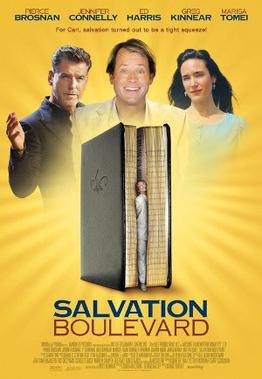

In [5]:
from PIL import Image

some_movie = movies_df.sample()

def get_image(movie_id: int) -> Image:
    """
    Get the image for the given movie
    """
    try:
        return Image.open(IMAGES_DIR / f"{movie_id}.jpg")
    except FileNotFoundError:
        return Image.new('RGB', (100, 100))

display(some_movie.transpose())
get_image(some_movie.index[0])

## Upload movies!

Now, we have all movies in the `images` folder and the movies data in the `movies.parquet` file.
We can proceed to do a nice little pipeline to send them to Weaviate. 

We will process the embeddings of the movies into a collection, we will vectorize the movies
plots and titles so we can do some RAG or content generation later.

We will use a Weaviate Cloud cluster and use the OpenAI vectorizer, which is easier to use than 
others out there.

In [9]:
from movie_genie.database import weaviate_connect_client

client = weaviate_connect_client()

First, we create the collection (wipe out if it existed before)

In [102]:
from movie_genie.database import create_collections


create_collections()

Check if the collection was created

In [10]:
from movie_genie.database import get_movies_collection

get_movies_collection()

Now, let's import all movies (in a batches) and display the progress.
Weaviate sometimes fails so we keep track of errors

In [104]:
from tqdm import tqdm


def add_movies_batch(movies: pd.DataFrame):
    """
    Add some initial movies to the database
    """
    client = weaviate_connect_client()
    batch_size = 100 # How many movies to add in each batch (for progress purposes)
    with client.batch.dynamic() as batch, \
        tqdm(total=len(movies), unit="movie", desc="Importing movies") as pbar:
        for idx in range(0, len(movies), batch_size):
            movies_batch = movies.iloc[idx:idx+batch_size]

            for movie_id, row in movies_batch.iterrows():
                batch.add_object("Movies", {
                    "movie_id": movie_id,
                    "plot": row['plot'],
                    "title": row['title'],
                })
            
            batch.flush()
            pbar.set_postfix_str(f"errors: { batch.number_errors}", refresh=False)
            pbar.update(len(movies_batch))


movies_df = read_csv_files()

add_movies_batch(movies_df)

Importing movies:  69%|██████▉   | 12300/17830 [10:45<04:45, 19.35movie/s, errors: 134]/Users/igui/.pyenv/versions/3.11.8/envs/movie-genie/lib/python3.11/site-packages/weaviate/warnings.py:260: UserWarning: Bat005: Rate limit reached with error connection to: OpenAI API failed with status: 503 error: Service Unavailable..
            Sleeping for 62 seconds.
  warnings.warn(
Importing movies: 100%|██████████| 17830/17830 [15:44<00:00, 18.88movie/s, errors: 293]


Now, we check the uploaded movies

In [6]:
from tqdm import tqdm
from weaviate.collections.classes.internal import Object, Properties

def get_uploaded_movies() -> list[Object[Properties, None]]:
    """
    Get the existing movies from the collection
    """
    collection = get_movies_collection()
    
    res = []
    with tqdm(desc="Getting uploaded movies", unit="movie") as pbar:
        for movie in collection.iterator(return_properties=['title', 'movie_id']):
            res.append(movie)
            pbar.update(1)
    return res

uploaded_movies = get_uploaded_movies()
len(uploaded_movies)

NameError: name 'get_movies_collection' is not defined

We check how many movies are missing

In [135]:
def get_missing_movies(
        movies_df: pd.DataFrame,
        uploaded_movies: list[Object[Properties, None]]
    ) -> pd.DataFrame:
    """
    Get the movies that are in the DataFrame but not in the database
    """
    existing_movies_ids = { movie.properties['movie_id'] for movie in uploaded_movies }
    missing_movies = movies_df[~movies_df.index.isin(existing_movies_ids)]
    return missing_movies

missing_movies = get_missing_movies(movies_df, uploaded_movies)
missing_movies

,title,image,plot
9044,Operator (2015 film),https://upload.wikimedia.org/wikipedia/en/c/cd...,Pamela Miller (Pam) is a married lady who live...
9045,Operator (2016 film),https://upload.wikimedia.org/wikipedia/en/4/41...,Joe (Martin Starr) is a programmer with a crip...
9046,Ophelia (2018 film),https://upload.wikimedia.org/wikipedia/en/b/b6...,"In the castle of Elsinore, Denmark, willful an..."
9047,Ordinary World (film),https://upload.wikimedia.org/wikipedia/en/3/35...,"In 1995, Perry Miller performs in New York wit..."
9048,Other People (film),https://upload.wikimedia.org/wikipedia/en/9/96...,"David Mulcahey (Jesse Plemons), a struggling c..."
...,...,...,...
16995,Steal Big Steal Little,https://upload.wikimedia.org/wikipedia/en/4/49...,"Mild-mannered, unassuming Ruben Martinez has a..."
16996,Steel (1997 film),https://upload.wikimedia.org/wikipedia/en/b/be...,John Henry Irons is a weapons designer who inv...
16997,Steel Frontier,https://upload.wikimedia.org/wikipedia/en/0/00...,"In 2019, a gang of bandits called the United R..."
16998,Steel Sharks,https://upload.wikimedia.org/wikipedia/en/a/a6...,A news report announces a revolution has overt...


## Make some queries

Now that we have the movies uploaded, we can do some sample queries to mess around with the API

In [11]:
from weaviate.classes.query import MetadataQuery

def query_similar(q: str, limit: int = 5) -> list[Object[Properties, MetadataQuery]]:
    """
    Query the database for similar movies
    """
    movies = get_movies_collection()
    ret = movies.query.near_text(
        q, 
        limit=limit, 
        return_properties=['movie_id', 'title', 'plot'],
        return_metadata=MetadataQuery(distance=True, certainty=True)
    )
    return ret.objects


for movie in query_similar("Movie about a robot"):
    print(f"{movie.metadata.certainty:.3f} - {movie.properties['title']}")
    print(movie.properties['plot'])
    print()

0.808 - Robot Stories
The film is divided up to four short stories:  My Robot Baby A young Marcia hides in the closet from her parents' fighting due to a mistake she has made. Marcia apologizes when her mother finds her in the closet; her mother tells Marcia to never fall in love, get married, and have children. Twenty-five years later, Marcia is married to Ray and they are looking towards adopting a child. After going to an adoption clinic, they apply for an adoption trial where they take care of a robotic baby before they can adopt a human child. Marcia begins to struggle when she is alone to take care of the robot baby, as she becomes flustered with what to do when the baby cries. Marcia brings the robot baby to her father, a handyman, and sees if he can tamper with the electronics of the robot. However, Marcia’s father worries that the doctors of the adoption clinic will detect the alteration of the robot. Nonetheless, Marcia persists on getting the baby reprogrammed and leaves the

Let's do another query and now plotting the images

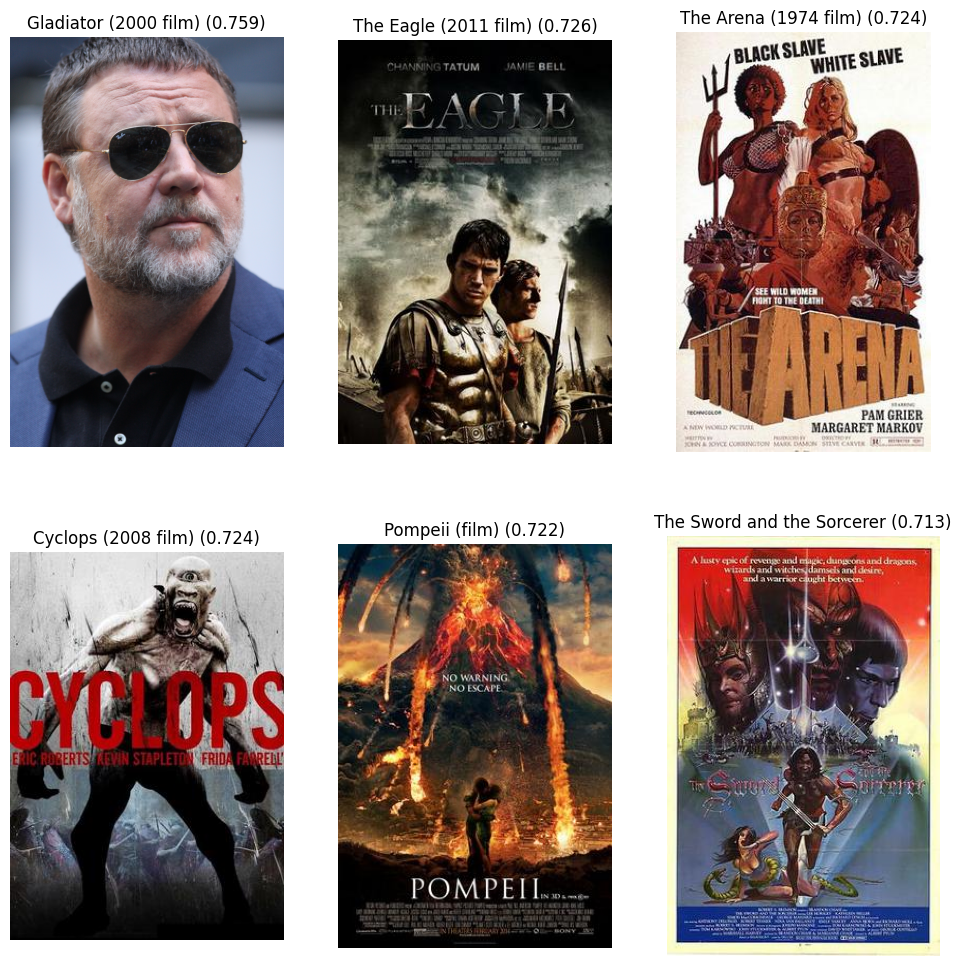

In [12]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

similar_movies = query_similar("Tale about a warrior that fights in Rome", limit=6)
imgs = [ get_image(movie.properties['movie_id']) for movie in similar_movies ]

fig, axs = plt.subplots(2, 3, figsize=(12, 12))
axs: list[Axes] = axs.flatten()
for movie, img, ax in zip(similar_movies, imgs, axs):
    ax.set_title(
        f"{movie.properties['title']} ({movie.metadata.certainty:.3f})",
    )
    ax.set_axis_off()
    ax.imshow(img)
plt.show()

Stuff to remove later

In [16]:
from movie_genie.database import get_movies_collection

movies_collection = get_movies_collection()

ImportError: cannot import name 'get_movies_collection' from 'movie_genie.database' (/Users/igui/src/movie-genie/movie_genie/database.py)